# Splunk App for Data Science and Deep Learning - Multivariate LSTM Example

This notebook contains an example workflow for training and applying a multivariate LSTM.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [2]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
import tensorflow as tf
# restrict GPU memory https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            #logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# ...
# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"

In [3]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.26.4
pandas version: 2.2.0


## Stage 1 - get a data sample from Splunk
In Splunk run a search to pipe a dataset into your notebook environment. Note: mode=stage is used in the | fit command to do this.

| inputlookup server_power.csv <br/>
| streamstats count <br/>
| eventstats max(count) as records <br/>
| eval train_split=round(records*0.7) <br/>
| appendpipe <br/>
    \[| where count<train_split <br/>
    | fit MLTKContainer mode=stage algo=multivariate_lstm "ac_power" from "total-unhalted_core_cycles" "total-instructions_retired" "total-last_level_cache_references" "total-memory_bus_transactions" "total-cpu-utilization" "total-disk-accesses" "total-disk-blocks" "total-disk-utilization" epochs=5 batch_size=50 previous_steps=2 into app:lstm_ac_power\] 

After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("barebone_model" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [8]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [9]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("lstm_ac_power")
param

{'options': {'params': {'mode': 'stage',
   'algo': 'multivariate_lstm',
   'epochs': '5',
   'batch_size': '50',
   'previous_steps': '2'},
  'args': ['ac_power',
   'total-unhalted_core_cycles',
   'total-instructions_retired',
   'total-last_level_cache_references',
   'total-memory_bus_transactions',
   'total-cpu-utilization',
   'total-disk-accesses',
   'total-disk-blocks',
   'total-disk-utilization'],
  'target_variable': ['ac_power'],
  'feature_variables': ['total-unhalted_core_cycles',
   'total-instructions_retired',
   'total-last_level_cache_references',
   'total-memory_bus_transactions',
   'total-cpu-utilization',
   'total-disk-accesses',
   'total-disk-blocks',
   'total-disk-utilization'],
  'model_name': 'lstm_ac_power',
  'algo_name': 'MLTKContainer',
  'mlspl_limits': {'disabled': False,
   'handle_new_cat': 'default',
   'max_distinct_cat_values': '10000',
   'max_distinct_cat_values_for_classifiers': '10000',
   'max_distinct_cat_values_for_scoring': '10000',


## Stage 2 - create and initialize a model

In [10]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    # Determine the number of features in the data
    n_features = df[param['feature_variables']].shape[1]
    
    # Set the model parameters depending on the input variables
    previous_steps = 3
    hidden_layers = 30
    activation_func = 'tanh'
    
    if 'options' in param:
        if 'params' in param['options']:
            if 'previous_steps' in param['options']['params']:
                previous_steps = int(param['options']['params']['previous_steps'])
            if 'hidden_layers' in param['options']['params']:
                hidden_layers = int(param['options']['params']['hidden_layers'])
            if 'activation' in param['options']['params']:
                activation_func = param['options']['params']['activation']
    
    model = Sequential()
    model.add(LSTM(units=hidden_layers, activation=activation_func, return_sequences=True, input_shape=(previous_steps, n_features)))
    model.add(LSTM(units=hidden_layers))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [11]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(init(df,param))
model=init(df,param)

## Stage 3 - fit the model

In [12]:
# train your model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    X = df[param['feature_variables']]
    y = df[param['target_variables']]
    
    # Determine how many features are in the dataset
    n_features = X.shape[1]
    
    # Determine the batch size and epochs
    previous_steps=3
    model_batch_size=10
    model_epochs=100

    if 'options' in param:
        if 'params' in param['options']:
            if 'previous_steps' in param['options']['params']:
                previous_steps = int(param['options']['params']['previous_steps'])
            if 'epochs' in param['options']['params']:
                model_epochs = int(param['options']['params']['epochs'])
            if 'batch_size' in param['options']['params']:
                model_batch_size = int(param['options']['params']['batch_size'])

    # Scale the input data
    scaler = MinMaxScaler()
    X_ss = scaler.fit_transform(X)

    # Loop through the data to ensure you have the correct input and output for the LSTM
    input_data=[]
    output_data=[]
    for i in range(X_ss.shape[0]-previous_steps-1):
        t=[]
        for j in range(0,previous_steps):
            t.append(X_ss[i+j])

        input_data.append(t)
        output_data.append(y.iloc[i+previous_steps])

    X = np.array(input_data)
    y = np.array(output_data)

    X = X.reshape(X.shape[0],previous_steps, n_features)

    print("Training data contains ", X.shape[0], " records of shape ", X.shape)
    
    # fit network
    history = model.fit(X, y, epochs=model_epochs, batch_size=model_batch_size, validation_data=(X, y), verbose=2, shuffle=False)
    info = {"message": "model trained"}
    return info

In [13]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
import time
start = time.time()
print(fit(model,df,param))
end = time.time()
elapsed = end-start
print("Training in seconds: ", elapsed)

Training data contains  21885  records of shape  (21885, 2, 8)
Epoch 1/5
438/438 - 6s - loss: 221.5606 - val_loss: 210.6462 - 6s/epoch - 14ms/step
Epoch 2/5
438/438 - 3s - loss: 203.1495 - val_loss: 195.9071 - 3s/epoch - 6ms/step
Epoch 3/5
438/438 - 3s - loss: 189.0107 - val_loss: 182.1509 - 3s/epoch - 6ms/step
Epoch 4/5
438/438 - 3s - loss: 175.4334 - val_loss: 168.7080 - 3s/epoch - 6ms/step
Epoch 5/5
438/438 - 3s - loss: 162.0700 - val_loss: 155.4087 - 3s/epoch - 6ms/step
{'message': 'model trained'}
Training in seconds:  18.098248720169067


## Stage 4 - apply the model

In [14]:
# apply your model
# returns the calculated results
def apply(model,df,param):
    y_hat = np.zeros(df.shape[0]) 
    
    X = df[param['feature_variables']]
    n_features = X.shape[1]
    
    # Determine the batch size and epochs
    previous_steps=3

    if 'options' in param:
        if 'params' in param['options']:
            if 'previous_steps' in param['options']['params']:
                previous_steps = int(param['options']['params']['previous_steps'])
    
    # Scale the input data
    scaler = MinMaxScaler()
    X_ss = scaler.fit_transform(X)

    # Loop through the data to ensure you have the correct input and output for the LSTM
    input_data=[]
    output_data=[]
    for i in range(X_ss.shape[0]-previous_steps-1):
        t=[]
        for j in range(0,previous_steps):
            t.append(X_ss[i+j])

        input_data.append(t)

    X = np.array(input_data)
    X = X.reshape(X.shape[0],previous_steps, n_features)
    
    predictions = model.predict(X)
    
    for k in range(y_hat.shape[0]):
        if k > previous_steps:
            y_hat[k]=predictions[k-previous_steps-1]
    
    result = pd.DataFrame(y_hat, columns=['prediction'])
    return result

684/684 [==============================] - 2s 2ms/step
       prediction
0        0.000000
1        0.000000
2        0.000000
3       79.906837
4       79.913437
...           ...
21883   79.949142
21884   79.949142
21885   79.949142
21886   79.949142
21887   79.949135

[21888 rows x 1 columns]
 28/684 [>.............................] - ETA: 1s 

/tmp/ipykernel_1297/3732361808.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat[k]=predictions[k-previous_steps-1]


684/684 [==============================] - 1s 2ms/step


/tmp/ipykernel_1297/3732361808.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat[k]=predictions[k-previous_steps-1]


21888


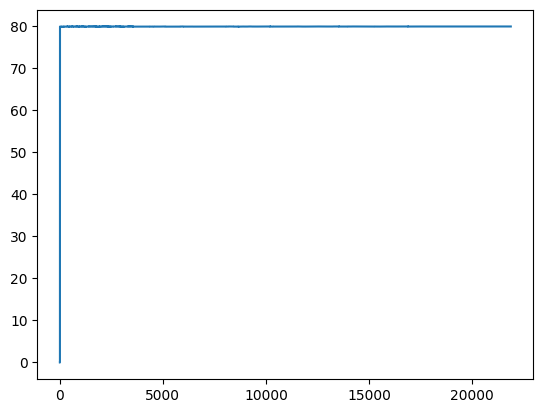

In [15]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(apply(model,df,param))
predictions=apply(model,df,param)

print(df.shape[0])

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(predictions)

## Stage 5 - save the model

In [16]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
    model.save(MODEL_DIRECTORY + name + ".keras")
    return model

In [17]:
save(model,"lstm_ac_power")

## Stage 6 - load the model

In [19]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
    model = load_model(MODEL_DIRECTORY + name + ".keras")
    return model

In [21]:
model2 = load("lstm_ac_power")
model2

## Stage 7 - provide a summary of the model

In [22]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__} }
    return returns

## End of Stages
All subsequent cells are not tagged and can be used for further freeform code